## 3. Basic feature engineering and analysis:

In [21]:
#import libraries....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load the data
data = pd.read_csv("final_data.csv")
data.drop("Unnamed: 0",axis=1,inplace=True)

In [6]:
data.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_score', 'customer_unique_id',
       'zip_code_prefix_customer', 'lat_customer', 'lng_customer',
       'customer_city', 'customer_state', 'product_id', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_item_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'zip_code_prefix_seller', 'lat_seller', 'lng_seller',
       'seller_city', 'seller_state', 'product_category_name'],
      dtype='object')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113105 non-null  object 
 1   payment_sequential             113105 non-null  int64  
 2   payment_type                   113105 non-null  object 
 3   payment_installments           113105 non-null  int64  
 4   payment_value                  113105 non-null  float64
 5   customer_id                    113105 non-null  object 
 6   order_status                   113105 non-null  object 
 7   order_purchase_timestamp       113105 non-null  object 
 8   order_approved_at              113105 non-null  object 
 9   order_delivered_carrier_date   113105 non-null  object 
 10  order_delivered_customer_date  113105 non-null  object 
 11  order_estimated_delivery_date  113105 non-null  object 
 12  review_score                  

In [33]:
#lets change the datetime features to correct format
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
data["order_approved_at"] = pd.to_datetime(data["order_approved_at"])
data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["order_estimated_delivery_date"] = pd.to_datetime(data["order_estimated_delivery_date"])
data["shipping_limit_date"] = pd.to_datetime(data["shipping_limit_date"])


### 3.1 Time based features:

<b> The most important thing in e-commerce is delivery time. If the product is not delivered in promised time, then there is high chance that the customer is not satisfied. Also if the promised time itself is too long, then also the customer could be unhappy. If the customer gets the product earlier than the estimated time, then there is chance that the customer giving review_score high. 
    
So, based on this research, I am creating some features which are based on the timestamps given in the dataframe. 

In [34]:
#Time of estimated delivery
data["estimated_time"] = (data["order_estimated_delivery_date"]-data["order_purchase_timestamp"]).apply(
                                                                                     lambda x: x.total_seconds()/3600)

In [20]:
#Time taken for delivery
data["actual_time"] = (data["order_delivered_customer_date"]-data["order_purchase_timestamp"]).apply(
                                                                                     lambda x: x.total_seconds()/3600)

In [21]:
#Difference between actual delivery time and estimated delivery time
data["diff_actual_estimated"] = (data["order_delivered_customer_date"] - data["order_estimated_delivery_date"]).apply(
                                                                                     lambda x: x.total_seconds()/3600)

In [22]:
# difference between purchase time and approved time 
data["diff_purchased_approved"] = (data["order_approved_at"] - data["order_purchase_timestamp"]).apply(
                                                                                     lambda x: x.total_seconds()/3600)

In [36]:
# difference between purchase time and courrier delivery time 
data["diff_purchased_courrier"] = (data["order_delivered_carrier_date"] - data["order_purchase_timestamp"]).apply(
                                                                                     lambda x: x.total_seconds()/3600)

### 3.2 Distance based features :

<b> We have observed that, Many most of the customers are from state SP and most of the sellers are from SP. And most of the products that are sold from the user of SP got review_rating 5. 

So, I am assuming, distance between seller and customer could be one aspect that affect customer satisfaction. i.e. If the distance is more then there could be a chance that customer is not satisfied and give review_score less. 

Based on this assumption I am creating new feature 'distance', whic is the  distance between seller location and customer location in kilo metre.

In [24]:
from math import radians
from sklearn.metrics.pairwise import haversine_distances

In [25]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
X = []  # list to store customer latitude and longitude
Y = []  # list to store seller latitude and longitude

for i in range(len(data)):
    X.append([radians(data.lat_customer[i]),radians(data.lng_customer[i])])
    Y.append([radians(data.lat_seller[i]),radians(data.lng_seller[i])])
    
#converting to numpy array    
cust_loc = np.array(X)
seller_loc = np.array(Y)


distance=[]
for i in range(len(data)):
    #calculating distance and multiplying by radius of earth(6371) to get distance in km
    dist = haversine_distances([cust_loc[i], seller_loc[i]])*6371
    distance.append(dist[0,1])
    
data["distance"] = distance

<b> Speed of delivery is also plays important role. Let us create "speed" feature using ditance and actual time features.
    
<font color="red">Since we are creating features using existing feature there could be chance of multicollinearity. But for now let us create the feature. After analysing we can drop features which are not helpful.

In [26]:
#speed = distance/time
data["speed"] = data["distance"]/data["actual_time"]

### 3.3 Binary features like same city or not, same state or not

<b> 1 if customer state and seller state are same, 0 otherwise

In [27]:
# 1 if customer state and seller state are same, 0 otherwise
same = []
for i in range(len(data)):
    if data.customer_state[i] == data.seller_state[i]:
        same.append(1)
    else:
        same.append(0)
        
data["same_state"] = same

In [59]:
data['customer_city'].value_counts()

sao paulo                  17881
rio de janeiro              7810
belo horizonte              3134
brasilia                    2113
curitiba                    1770
                           ...  
pancas                         1
nova floresta                  1
aparecida de sao manuel        1
nobres                         1
presidente juscelino           1
Name: customer_city, Length: 4001, dtype: int64

<b> 1 if customer city and seller city are same, 0 otherwise

In [57]:
#https://www.kaggle.com/sophiecrespo/oc-ia-p5-eda
from unidecode import unidecode
def lower_and_ascii(string):
    return unidecode(string.lower())


In [58]:
data['customer_city'] = data.apply(lambda row: lower_and_ascii(row['customer_city']), axis=1)
data['seller_city'] = data.apply(lambda row: lower_and_ascii(row['seller_city']), axis=1)

In [30]:
same = []
for i in range(len(data)):
    if data.customer_city[i] == data.seller_city[i]:
        same.append(1)
    else:
        same.append(0)

data["same_city"] = same

<b> 1 if shipping was late than limit time , 0 otherwise

In [31]:
late = []

for i in range(len(data)):
    if data.shipping_limit_date[i] < data.order_delivered_carrier_date[i]:
        late.append(1)
    else:
        late.append(0)
        
data["late_shipping"] = late

<b> 1 if freight_value is higher than price of product, 0 otherwise

In [32]:
high = []

for i in range(len(data)):
    if data.price[i] < data.freight_value[i]:
        high.append(1)
    else:
        high.append(0)
        
data["high_freight"] = high

<b> - We have created 11 new features using existing features. Some features may not be useful. 
    - But by using some new features we can drop the original features, those which could cause high dimenionality.
        - We have created distance feature using longitude and latitude. So seller and customer longitude lattitude are not required while modelling. Similarly all timestamps, customer and seller city names. But right now we will not make any decision on these. 

<b> Now, we need to analyse the engineered features. 

### Analysis On New Features

<b> Time based features.

<b> 1.estimated_time

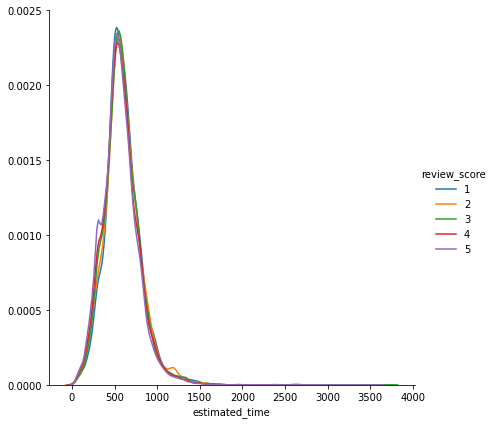

In [33]:
#data["estimated_time"]

sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"estimated_time")\
    .add_legend()
plt.show()

* pdf of estimated time of all reviews overlapped.
* We cannot say anything more from the plot.
* Let us analyse some percentiles to get clear idea

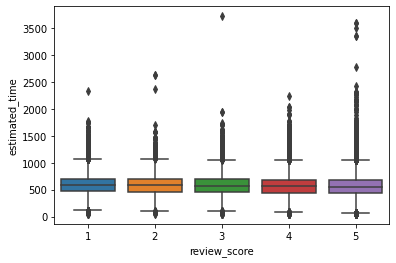

Mean 
 review_score
1    598.053128
2    595.990385
3    587.066812
4    575.873394
5    561.647707
Name: estimated_time, dtype: float64
90 percentile 
 review_score
1    847.205278
2    856.274278
3    834.527944
4    828.147444
5    818.422444
Name: estimated_time, dtype: float64


In [34]:
#boxplots
sns.boxplot(y="estimated_time",x="review_score",data=data)
plt.show()

#mean estimated_time
print("Mean \n",data.groupby("review_score")["estimated_time"].mean())

#90th percentile estimated_time
print("90 percentile \n",data.groupby("review_score")["estimated_time"].apply(lambda x: np.percentile(x,90)))

* From the boxplot we can see that there are outliers. 
* Box plots for all review_scores are at almost same phase.
* Mean estimated time is more for review_score 1
* Also we can see that mean estimated time is increasing from review_score 5 to review_score 1.
* 90th percentile value also follows same trend. But 90th percentile is high for review_score 2. Since estimated time has more outliers, high percentiles could be affected by outliers. 

In [35]:
lst=[50,75,80,85]    #let us check these percentile values
for i in lst:
    print("{}th percentile \n {}".format(i,data.groupby("review_score")["estimated_time"].apply(lambda x: np.percentile(x,i))))
    print("*"*40)

50th percentile 
 review_score
1    579.394444
2    579.462222
3    566.590556
4    560.511389
5    550.993889
Name: estimated_time, dtype: float64
****************************************
75th percentile 
 review_score
1    706.353333
2    706.061389
3    700.436389
4    685.589722
5    677.710556
Name: estimated_time, dtype: float64
****************************************
80th percentile 
 review_score
1    747.439444
2    750.799167
3    734.944111
4    728.890278
5    710.062389
Name: estimated_time, dtype: float64
****************************************
85th percentile 
 review_score
1    791.740278
2    794.336222
3    777.705833
4    776.583722
5    757.014333
Name: estimated_time, dtype: float64
****************************************


* Median of estimated time is also high for review_score 1
* General trend in the analysed percentiles  
    - estimated_time of ( 5 < 4 < 3 < 2 <=1)
    - Most importantly estimated time of score 5 < estimated time of score 1.
* Though the difference are not very significant, we can assume that,
<b> More the estimated time, there is high chance of getting review_score less from the customer. Shorter the estimated time, there is high chance of getting high rating from customer.

<b> 2. Time taken for delivery

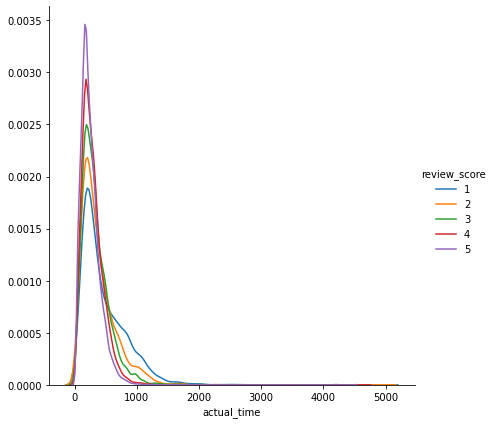

In [36]:
##Time taken for delivery

sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"actual_time")\
    .add_legend()
plt.show()

* Here we can see that, pdf of review_score 1 is at higher height for higher actual times. Where as review_score is below score 1, and 3 is below 2, and 4 is below 3, and 5 is below 4.
* This is actually good sign, since review_score are not highly overlapped incase of actual_time feature.
* For lower values of actual_time, pdf of review_score 5 is highly peaked. followed by 4,3,2,1.
* pdf of review_score 5 falls very sharply in the right side compared to pdf of review_score 1.

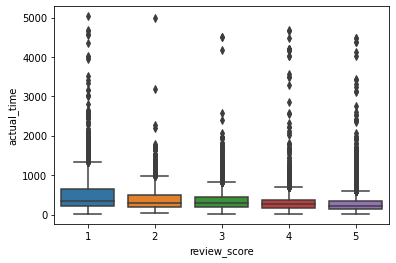

Mean 
 review_score
1    470.694890
2    379.855595
3    336.973243
4    293.799355
5    255.782775
Name: actual_time, dtype: float64
90 percentile 
 review_score
1    957.735556
2    744.601611
3    617.164889
4    521.212111
5    457.132778
Name: actual_time, dtype: float64


In [37]:
#boxplots
sns.boxplot(y="actual_time",x="review_score",data=data)
plt.show()

#mean actual_time
print("Mean \n",data.groupby("review_score")["actual_time"].mean())

#90th percentile actual_time
print("90 percentile \n",data.groupby("review_score")["actual_time"].apply(lambda x: np.percentile(x,90)))

* From the box plot also we can see that, place of boxplot for review_score 5 is lower compared to that of review_score 1.
* There are outliers, But position of boxplot is increasing from review_score 5 to review_score 1.
* Though there is perfect separation, this feature definitely has some importance while classifying review_scores.

* Mean actual time is significantly less for review_score 5 compared to that of review_score 1.
* And the trend is mean of actual time ( 5 < 4 << 3 < 2 < 1)
* For the 90th percentiles also the same observation holds. 

In [38]:
#let us analyse some other percentiles and median, since it has outliers.

lst=[50,75,80,85]    #let us check these percentile values
for i in lst:
    print("{}th percentile \n {}".format(i,data.groupby("review_score")["actual_time"].apply(lambda x: np.percentile(x,i))))
    print("*"*40)

50th percentile 
 review_score
1    355.453056
2    297.690278
3    285.297778
4    257.618056
5    221.191944
Name: actual_time, dtype: float64
****************************************
75th percentile 
 review_score
1    660.068889
2    500.805556
3    436.795556
4    378.498056
5    331.339722
Name: actual_time, dtype: float64
****************************************
80th percentile 
 review_score
1    745.365556
2    556.916833
3    482.829722
4    413.892778
5    360.589444
Name: actual_time, dtype: float64
****************************************
85th percentile 
 review_score
1    841.545833
2    645.601167
3    534.920278
4    460.392833
5    402.471722
Name: actual_time, dtype: float64
****************************************


* Median of actual time is also follows the same trend as Mean follows. (5<4<3<2<1)
* And difference between 5 and 1 is high. 
* Similarly this holds for all the percentiles values that we analysed.

<b> This means if the delivery time is more, then there is high chance that the product gets lower ratings. If delivery time is less, then there is more chances of getting high rating. 

<b> 3. diff_actual_estimated

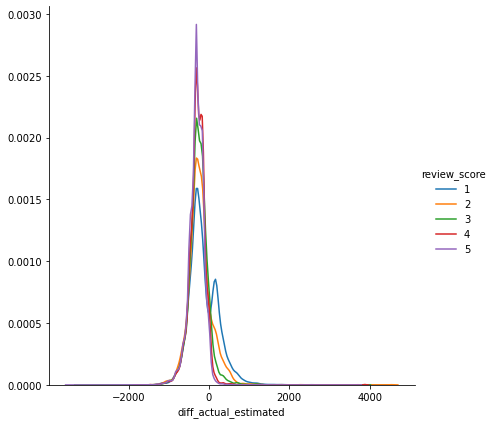

In [39]:
#diff_actual_estimated

sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"diff_actual_estimated")\
    .add_legend()
plt.show()

* difference between actual delivery time and estimated time is very important feature. 
* From the pdf we can see that, review_score 5 has high density below 0. That means if the product is delivered before the estimated time.
* Though review_score has high density near 0, it has one another peak for greater than 0. And in that place review_score 5 has almost 0 density. 
* This feature is helpful while classifying the review_scores.

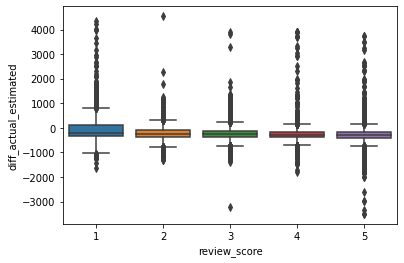

Mean 
 review_score
1   -127.358238
2   -216.134790
3   -250.093569
4   -282.074038
5   -305.864932
Name: diff_actual_estimated, dtype: float64
Median 
 review_score
1   -198.916944
2   -245.708611
3   -254.533056
4   -281.126944
5   -296.024444
Name: diff_actual_estimated, dtype: float64
90 percentile 
 review_score
1    326.899722
2    159.982722
3     11.281500
4    -60.103556
5   -100.358056
Name: diff_actual_estimated, dtype: float64


In [40]:
#boxplots
sns.boxplot(y="diff_actual_estimated",x="review_score",data=data)
plt.show()

#mean diff_actual_estimated
print("Mean \n",data.groupby("review_score")["diff_actual_estimated"].mean())
#median diff_actual_estimated
print("Median \n",data.groupby("review_score")["diff_actual_estimated"].median())
#90th percentile diff_actual_estimated
print("90 percentile \n",data.groupby("review_score")["diff_actual_estimated"].apply(lambda x: np.percentile(x,90)))

* From the boxplots we can see that there are outliers. Fro review_score 5, there are more outlier points in the negative side compared to other review_scores. review_score 1 has more positive outliers.
* Mean difference is very low that means it is more negative for review_score 5 compared to that of review_score 1. 
* The trend is mean of difference ( 5 < 4 < 3 < 2 << 1)
* The same trend and observation can be seen from median values also. 
* For the 90th percentile, difference value is high for review_score 1 followed by review_score 2. review_score 5 is still negative and very less for 90th percentile value and also score 4 is also very less compared to 3,2,1 scores.

<b> This means, if the product is delivered before the estimated delivery time, then there is high chances of getting review_score 5 followed by 4. If delivery time exceeds estimated time of delivery, then there is high chances of getting lower review_score like 1 or 2. 
    

<b> 4. diff_purchased_approved

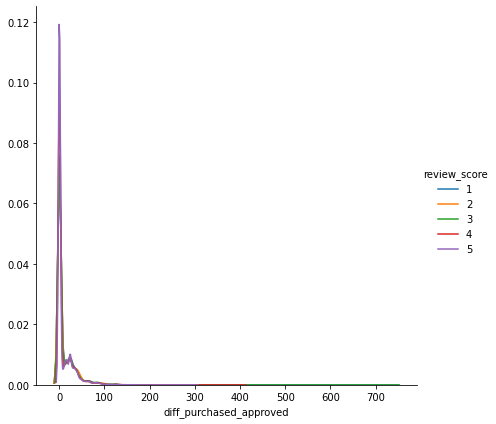

In [41]:
# diff_purchased_approved

sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"diff_purchased_approved")\
    .add_legend()
plt.show()

* pdf of all review_scores are highjly overlapped.
* We cannot distinguish among review_scores from this plot

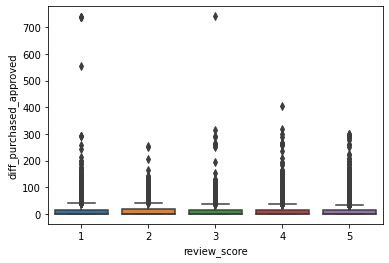

Mean 
 review_score
1    11.301371
2    11.116752
3    10.936094
4    10.371466
5    10.170415
Name: diff_purchased_approved, dtype: float64
Median 
 review_score
1    0.369167
2    0.357500
3    0.350556
4    0.339167
5    0.344167
Name: diff_purchased_approved, dtype: float64
90 percentile 
 review_score
1    36.032778
2    38.526111
3    36.275556
4    34.941944
5    34.443389
Name: diff_purchased_approved, dtype: float64


In [42]:
#boxplots
sns.boxplot(y="diff_purchased_approved",x="review_score",data=data)
plt.show()

#mean diff_purchased_approved
print("Mean \n",data.groupby("review_score")["diff_purchased_approved"].mean())
#median diff_purchased_approved
print("Median \n",data.groupby("review_score")["diff_purchased_approved"].median())
#90th percentile diff_purchased_approved
print("90 percentile \n",data.groupby("review_score")["diff_purchased_approved"].apply(lambda x: np.percentile(x,90)))

* Mean value, median value all are almost equal for all the review_scores. There is not much difference. 
* From the boxplot we can see that review_score 1 has some very large outliers. 
* But we cannot distinguish even partially from the diff_purchased_approved feature.
* This might not be helpful while classifying the review_scores.

<b> 5. diff_purchased_courrier

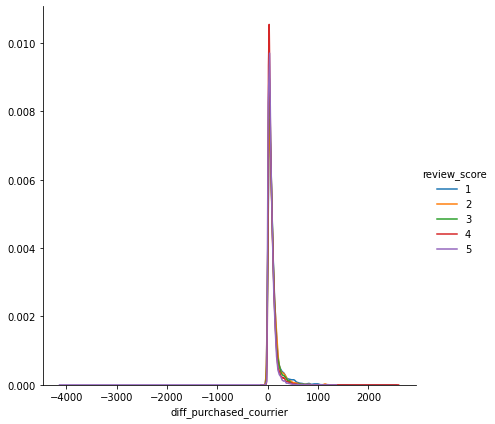

In [43]:
# diff_purchased_courrier

sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"diff_purchased_courrier")\
    .add_legend()
plt.show()

* From the pdf we cannot clearly separate review_scores. Plots are highly overlapped.
* For higher values of diff_purchased_courrier review_score 3 has slightly higher curve. 

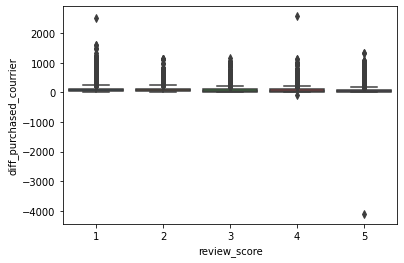

Mean 
 review_score
1    110.424622
2     97.078529
3     87.075198
4     78.096517
5     70.131928
Name: diff_purchased_courrier, dtype: float64
Median 
 review_score
1    70.642778
2    66.823056
3    62.483611
4    54.114444
5    50.320278
Name: diff_purchased_courrier, dtype: float64
90 percentile 
 review_score
1    234.320833
2    196.272722
3    179.313944
4    158.014056
5    144.118111
Name: diff_purchased_courrier, dtype: float64


In [44]:
#boxplots
sns.boxplot(y="diff_purchased_courrier",x="review_score",data=data)
plt.show()

#mean diff_purchased_courrier
print("Mean \n",data.groupby("review_score")["diff_purchased_courrier"].mean())
#median diff_purchased_courrier
print("Median \n",data.groupby("review_score")["diff_purchased_courrier"].median())
#90th percentile diff_purchased_courrier
print("90 percentile \n",data.groupby("review_score")["diff_purchased_courrier"].apply(lambda x: np.percentile(x,90)))

* Box plots are not at different phase. We can only say that there are outliers th in features.
* But, the mean value, median value and 90th percentile values for review_score are less compared to other review_scores.
* The trend is (5<4<3<2<1)
* That means there is chance that, if there is high difference in time of purchased and time of corrier shpping time,  cutomer could give low rating. But one thing here h\is, if this difference is large then there will be delay in delivery. Tht could affect the satisfaction of customer.

<b> 6. distance between seller location and customer location

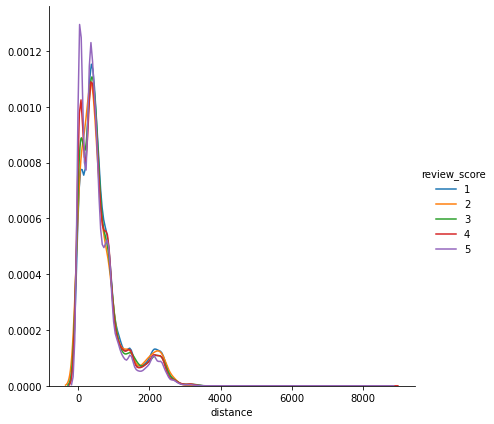

In [45]:
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"distance")\
    .add_legend()
plt.show()

* pdf of review_score 5 is highly peaked at smaller values of distance. For higher values density becomes less compared to other review_scores.
* For higher values of distances review_score 1 and 2 has higher density than other scores.

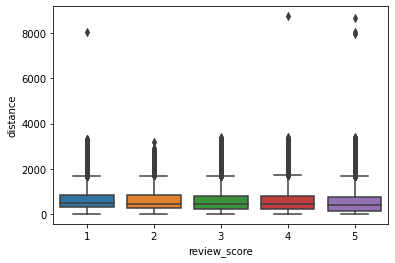

Mean 
 review_score
1    663.690800
2    641.471010
3    629.459496
4    619.527873
5    568.950961
Name: distance, dtype: float64
Median 
 review_score
1    484.730969
2    447.707393
3    462.874091
4    454.894136
5    410.211206
Name: distance, dtype: float64
90 percentile 
 review_score
1    1573.205232
2    1614.072123
3    1511.549772
4    1475.039366
5    1332.860596
Name: distance, dtype: float64


In [46]:
#boxplots
sns.boxplot(y="distance",x="review_score",data=data)
plt.show()

#mean distance
print("Mean \n",data.groupby("review_score")["distance"].mean())
#median distance
print("Median \n",data.groupby("review_score")["distance"].median())
#90th percentile distance
print("90 percentile \n",data.groupby("review_score")["distance"].apply(lambda x: np.percentile(x,90)))

* Boxplots are almost at same position. But boxplot of review_score 5 is slightly lower position compared to that of review_score 1.
* Mean, median and 90th percentile of distance values are less for revew_score 5 than other review_scores.
* Trend is (5<4<3<2<1)
* This feature could somewhat help us while classifying.
* That means if the distance between customer and seller increases then there are chances of getting lower rating.

<b> 7. speed

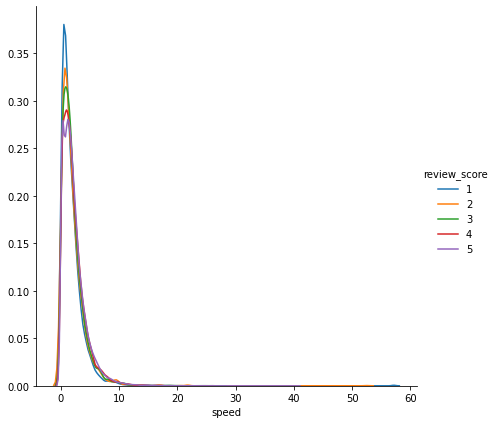

In [47]:
sns.FacetGrid(data,hue="review_score",height=6)\
    .map(sns.kdeplot,"speed")\
    .add_legend()
plt.show()

* For lower values of speed pdf of review_score 1 is highly peaked than other ratings. 
* peakedness of pdf of review_scores at lower values of speed decreases from review_score 1 to 5.
* For higher values of speed, review_score density is low compared to other scores.

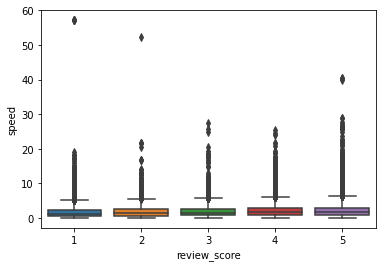

Mean 
 review_score
1    1.829121
2    1.989655
3    2.036370
4    2.185800
5    2.241600
Name: speed, dtype: float64
Median 
 review_score
1    1.303247
2    1.430599
3    1.553044
4    1.698774
5    1.747787
Name: speed, dtype: float64
90 percentile 
 review_score
1    3.922746
2    4.206390
3    4.312063
4    4.581428
5    4.715156
Name: speed, dtype: float64


In [48]:
#boxplots
sns.boxplot(y="speed",x="review_score",data=data)
plt.show()

#mean speed
print("Mean \n",data.groupby("review_score")["speed"].mean())
#median speed
print("Median \n",data.groupby("review_score")["speed"].median())
#90th percentile speed
print("90 percentile \n",data.groupby("review_score")["speed"].apply(lambda x: np.percentile(x,90)))

* Boxplots are almost at same position. review_score 1 is at slightly lower position compared to review_score 5.
* Mean, median, 90th percentile values are not very different. But the trend is (5>4>3>2>1) But this inequality is not so strong.

<b> 8. same_state

In [49]:
data.groupby("review_score")["same_state"].value_counts(normalize=True).unstack()*100

same_state,0,1
review_score,,
1,71.127558,28.872442
2,67.218122,32.781878
3,66.551760,33.448240
4,64.782509,35.217491
5,61.580828,38.419172


* % share of review_score 5 when customer and seller from same state is higher compared to that of other review_scores.
* % share of review_score 1 when customer and seller from different state, is higher compared to that of other review_scores.

<b> 9. same_city

In [50]:
data["same_city"].value_counts()

0    107202
1      5903
Name: same_city, dtype: int64

* There very few instances where, customer and sellers both belongs to same city.

In [51]:
data.groupby("review_score")["same_city"].value_counts(normalize=True).unstack()*100

same_city,0,1
review_score,,
1,96.027490,3.972510
2,96.029524,3.970476
3,95.717121,4.282879
4,95.065593,4.934407
5,94.215387,5.784613


* % share of review_score 5 when customer and seller from same city is higher compared to that of other review_scores.
* But there is not mcuh difference and there are very few common city instances.

<b> 10. late_shipping

In [52]:
data["late_shipping"].value_counts()

0    102641
1     10464
Name: late_shipping, dtype: int64

* There are few instances hwere shipping time exceeds shipping limit time.

In [53]:
data.groupby("review_score")["late_shipping"].value_counts(normalize=True).unstack()*100

late_shipping,0,1
review_score,,
1,83.422702,16.577298
2,85.747009,14.252991
3,88.780946,11.219054
4,91.309551,8.690449
5,92.655909,7.344091


* If shpping is late, then there is chances of getting low review_scores, since % share of review_score 1 incase of late_shipping is higher compared to the same that of other review_scores.

<b> 11. high_freight

In [54]:
data["high_freight"].value_counts()

0    108957
1      4148
Name: high_freight, dtype: int64

* There are very few instances when freight value is higher than price of the product. 
* Our assumption is if the freight value is higher than product price, then customer obviously not satisfied. 


In [55]:
data.groupby("review_score")["high_freight"].value_counts(normalize=True).unstack()*100

high_freight,0,1
review_score,,
1,95.249604,4.750396
2,95.571392,4.428608
3,95.832028,4.167972
4,96.460299,3.539701
5,96.631960,3.368040


* There is not much difference in % review_sharing between high_freight and not high freight.

<b><font color="darkblue"> From the EDA part and above analysis of new features............
    
    - We have analysed all the features and got some useful insights by considering review_score as target.
    - Most of the features alone cannot distinguish among review_scores. 
    - But in some features, there is a tendency of difference between review_score 5 and review_score 1.
    - There is no clear separation using simple rule based method incase of bivariate analysis also.
    - By the analysis of timestamp of purchase date, we got to know about the purchasing pattern in each year and month and hours. 
    - Most of the features are right skewed.
    - We have created some basic features using existing features. 
    - Time based features are seems to be helpful for classifying the review_scores. 
    - We have created some binary features like (same_state, same_city), so that we can drop the existing feature which has same information. 
    - Most of the features shows difference between review_score 1 and 5. But For review_score 2 and 3, there is not significant difference. 
    - Since the data has very few instances for review_score 2 and 3, and by the feature analysis, we can classify review_score 5 from 2 and 3. But classification between 2 and 3 is seems to be difficult. 
    - score 2 and 3 has few points and in the feature analysis also there is not clear separation found.
    - Inorder to overcome this difficulty we could use class balancing techniques like SMOTE. Or while modelling we can use algorithmic level approach models like LightGMB,RUSBoost. 
    - Since we have timestamp, we can do Time based splitting of data. 
    - After splitting, we could try some advanced features which are discussed in abstract.

In [56]:
#saving all the created features with data.
data.to_csv("data_with_basic_features.csv")